# Weapon Stats

## Setting Up

In [22]:
import pandas as pd
import calendar
from weapon import max_shots, firemode_shots

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

ImportError: cannot import name 'firemode_shots' from 'weapon' (D:\PycharmProjects\xcom-analysis-jupyter-notebook\enemy_unknown\weapon.py)

## Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

Soldiers start with an Accuracy value between 40 and 70, giving an average of 55.

To get the change of hit this should by applied to the weapon accuracy. Just multiply them as proportions. So an average of 55 to a weapon of Accuracy 90 means 0.55 * 0.9 = 0.495 chance of hit.

In [3]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: x["accuracy"] / 100 * 0.55, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760


## Derived Damage

In [5]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["expected_damage"] = weapon_attacks.apply(lambda x: x["damage"] * x["chance_to_hit"], axis=1)
weapon_attacks["clip_damage"] = weapon_attacks.apply(lambda x: x["capacity"] * x["damage"], axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turns_to_reload"] = weapon_attacks.apply(lambda x: x["capacity"] / x["turn_max_shots"], axis=1)
weapon_attacks["turn_damage_max"] = weapon_attacks.apply(lambda x: x["turn_max_shots"] * x["damage"], axis=1)
weapon_attacks["turn_damage_expected"] = weapon_attacks.apply(lambda x: x["turn_damage_max"] * x["chance_to_hit"], axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,32.175,90.0,1.269841,0.787500,114.285714,40.857143
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,18.942,588.0,1.250000,11.200000,52.500000,23.677500
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,19.844,616.0,1.250000,11.200000,55.000000,24.805000
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,21.648,672.0,1.250000,11.200000,60.000000,27.060000
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,7.392,588.0,7.500000,1.866667,315.000000,55.440000


## Weapon Stats

### Average Damage

Ignoring the rate of fire, but choosing the highest values among the fire modes.

In [6]:
average_damage = weapon_attacks[["weapon", "expected_damage"]]
average_damage = average_damage.groupby("weapon").max()
average_damage = average_damage.sort_values(by=["expected_damage"])
average_damage

,expected_damage
weapon,
pistol,11.1540
laser_pistol,17.2040
grenade,17.8750
rifle,18.1500
auto_cannon,21.6480
plasma_pistol,24.3100
proximity_grenade,25.0250
cannon_turret,29.7000
heavy_cannon,29.7000


Text(0, 0.5, 'Damage')

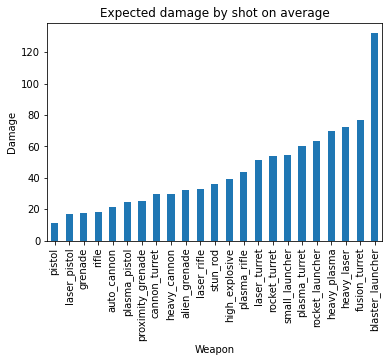

In [7]:
ax = average_damage.plot.bar(title="Expected damage by shot on average", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Ammo

In [8]:
weapon_ammo = weapon_attacks[["weapon", "capacity"]]
weapon_ammo = weapon_ammo.rename(columns={"capacity": "ammo"})
weapon_ammo = weapon_ammo.groupby("weapon").max()
weapon_ammo = weapon_ammo.sort_values(by=["ammo"])
weapon_ammo = weapon_ammo[weapon_ammo["ammo"] < 255]
weapon_ammo

,ammo
weapon,
alien_grenade,1.0
rocket_launcher,1.0
proximity_grenade,1.0
high_explosive,1.0
grenade,1.0
small_launcher,1.0
blaster_launcher,1.0
heavy_cannon,6.0
rocket_turret,8.0


Text(0, 0.5, 'Shots')

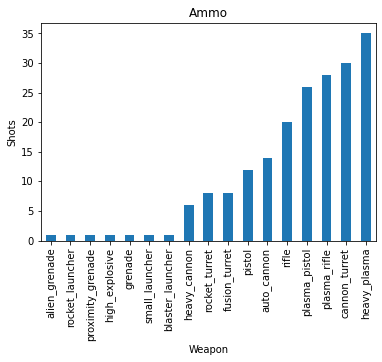

In [9]:
ax = weapon_ammo.plot.bar(title="Ammo", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Shots")

### Shots Per Turn

Supposing all the attacks are done on auto, or the highest rate of fire setting.

In [10]:
shots_per_turn = weapon_attacks[["weapon", "turn_max_shots"]]
shots_per_turn = shots_per_turn.rename(columns={"turn_max_shots": "turn_shots"})
shots_per_turn = shots_per_turn.groupby("weapon").max()
shots_per_turn = shots_per_turn.sort_values(by=["turn_shots"])
shots_per_turn

,turn_shots
weapon,
blaster_launcher,1.204819
alien_grenade,1.269841
grenade,1.269841
high_explosive,1.269841
proximity_grenade,1.269841
fusion_turret,1.515152
rocket_launcher,1.877934
small_launcher,2.040816
rocket_turret,2.222222


Text(0, 0.5, 'Shots')

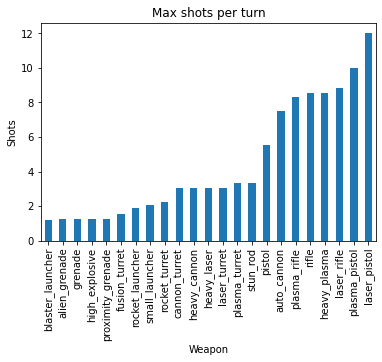

In [11]:
ax = shots_per_turn.plot.bar(title="Max shots per turn", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Shots")

### Turns of Sustained Fire

In [12]:
turns_sustained_fire = weapon_attacks[["weapon", "turns_to_reload"]]
turns_sustained_fire = turns_sustained_fire.groupby("weapon").max()
turns_sustained_fire = turns_sustained_fire.sort_values(by=["turns_to_reload"])
turns_sustained_fire = turns_sustained_fire.rename(columns={"turns_to_reload": "turns_sustained_fire"})

# Remove weapons with unlimited ammo
turns_sustained_fire = turns_sustained_fire[turns_sustained_fire["turns_sustained_fire"] < 100]

turns_sustained_fire

,turns_sustained_fire
weapon,
alien_grenade,0.7875
rocket_launcher,0.7875
proximity_grenade,0.7875
high_explosive,0.7875
grenade,0.7875
small_launcher,0.7875
blaster_launcher,0.8300
pistol,3.6000
heavy_cannon,4.8000


Text(0, 0.5, 'Turns')

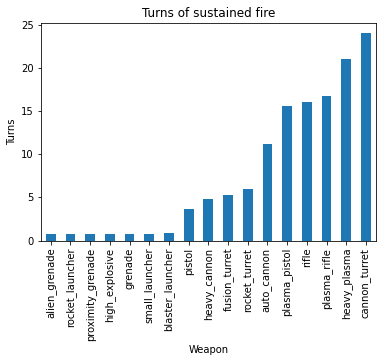

In [13]:
ax = turns_sustained_fire.plot.bar(title="Turns of sustained fire", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Turns")